<a href="https://colab.research.google.com/github/bkodzo/ML_Project/blob/main/health_costs_with_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

  Preparing metadata (setup.py) ... done
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2025-01-08 05:27:57--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv.2’

insurance.csv.2     100%[===================>]  49.09K  --.-KB/s    in 0.01s   

2025-01-08 05:27:57 (3.95 MB/s) - ‘insurance.csv.2’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [ ]:
dataset.shape

(1338, 7)

In [ ]:
#Checking For Missing Values
MissingVals = dataset.isnull().sum()
print("Missing values before cleaning:\n", MissingVals)


Missing values before cleaning:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64


In [ ]:
#Checking For Duplicates
duplicate_rows = dataset[dataset.duplicated(keep=False)]
print("\nDuplicate Rows:\n", duplicate_rows)



Duplicate Rows:
      age   sex   bmi  children smoker     region  expenses
195   19  male  30.6         0     no  northwest   1639.56
581   19  male  30.6         0     no  northwest   1639.56


In [ ]:
# Remove duplicate rows
dataset = dataset.drop_duplicates()
print("\nShape of data after removing duplicates:\n", dataset.shape)



Shape of data after removing duplicates:
 (1337, 7)


In [ ]:
# **Outlier Removal using IQR**
def remove_outliers_iqr(dataset):
    for col in dataset.select_dtypes(include=np.number).columns:
        Q1 = dataset[col].quantile(0.25)
        Q3 = dataset[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        dataset = dataset[(dataset[col] >= lower_bound) & (dataset[col] <= upper_bound)]
    return dataset


In [ ]:
dataset = remove_outliers_iqr(dataset)
print("\nShape of data after outlier removal:\n", dataset.shape)



Shape of data after outlier removal:
 (1190, 7)


array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'expenses'}>]], dtype=object)

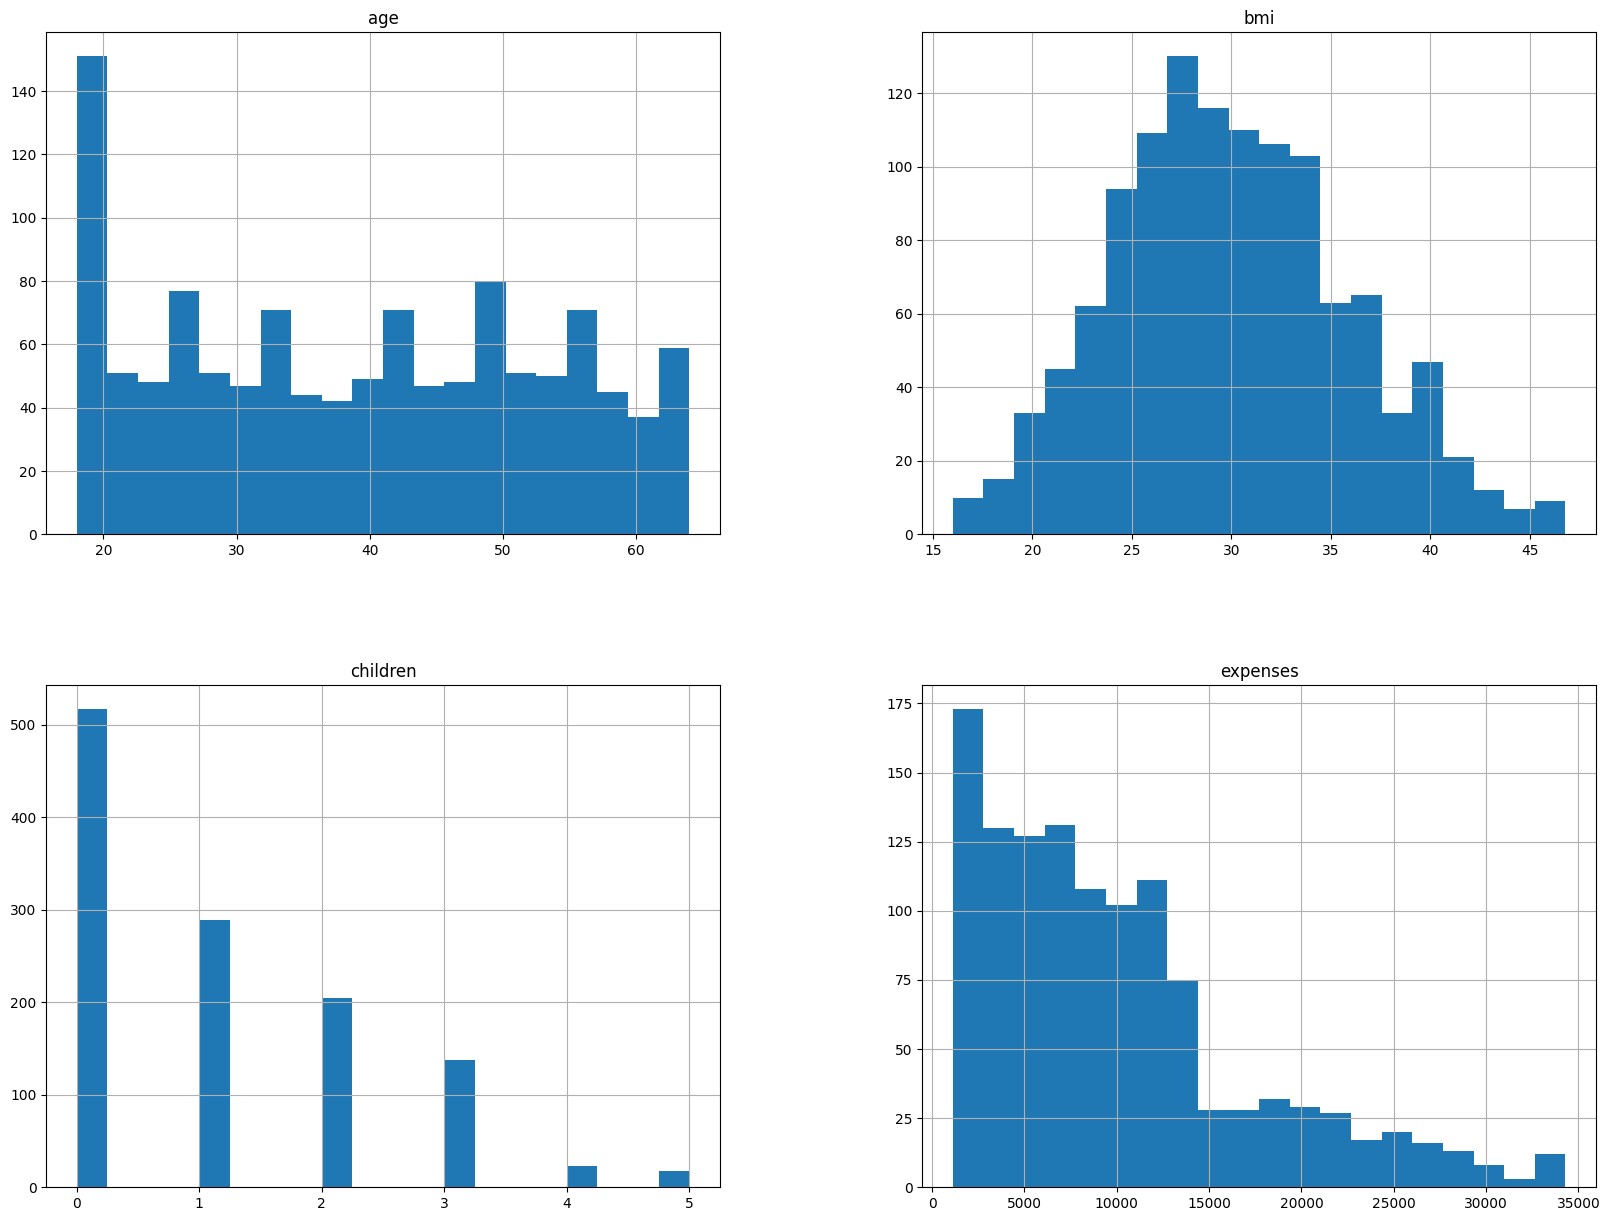

In [ ]:
 #Creating box plots for each feature
dataset.hist(bins=20, figsize=(20,15))

In [ ]:
from sklearn.preprocessing import StandardScaler

# Convert categorical columns to numerical using one-hot encoding
dataset = pd.get_dummies(dataset, columns=['sex', 'smoker', 'region'])

# Separate features and labels
labels = dataset.pop('expenses')

# Split data into train and test sets
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_labels = labels.loc[train_dataset.index]
test_labels = labels.loc[test_dataset.index]

#Feature Scaling using StandardScaler
scaler = StandardScaler()
numerical_cols = ['age', 'bmi', 'children']
train_dataset[numerical_cols] = scaler.fit_transform(train_dataset[numerical_cols])
test_dataset[numerical_cols] = scaler.transform(test_dataset[numerical_cols])


In [ ]:
# Define the model
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(0.001) # Adjusted learning rate
model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])

In [ ]:
# Train the model
history = model.fit(
    train_dataset, train_labels,
    epochs=1000, validation_split=0.2, verbose=0, # Increased epochs
    callbacks=[tfdocs.modeling.EpochDots()])



Epoch: 0, loss:144706512.0000,  mae:9765.3252,  mse:144706512.0000,  val_loss:161586160.0000,  val_mae:10408.7891,  val_mse:161586160.0000,  
....................................................................................................
Epoch: 100, loss:13048613.0000,  mae:2291.6401,  mse:13048613.0000,  val_loss:28760322.0000,  val_mae:3332.6887,  val_mse:28760322.0000,  
....................................................................................................
Epoch: 200, loss:11192780.0000,  mae:2244.5063,  mse:11192780.0000,  val_loss:31697340.0000,  val_mae:3457.3435,  val_mse:31697340.0000,  
....................................................................................................
Epoch: 300, loss:8906309.0000,  mae:1973.5352,  mse:8906309.0000,  val_loss:30408706.0000,  val_mae:3181.5330,  val_mse:30408706.0000,  
....................................................................................................
Epoch: 400, loss:7649599.5000,  mae:18

8/8 - 0s - 5ms/step - loss: 32561092.0000 - mae: 2679.7844 - mse: 32561092.0000
Testing set Mean Abs Error: 2679.78 expenses
You passed the challenge. Great job!
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


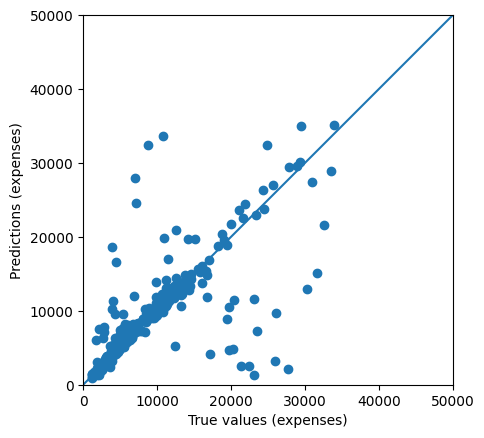

In [ ]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
